In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from mpl_toolkits import mplot3d

In [3]:
!pip install mnist

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

9


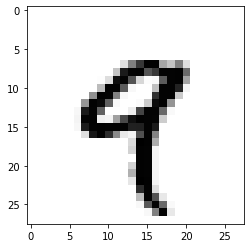

In [9]:
image_index = 4 
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys');

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]
y_train

array([3, 3, 3, ..., 8, 3, 8], dtype=uint8)

In [11]:
X_train = X_train/255.
X_test = X_test/255.

In [12]:
y_train1 = 1*(y_train==3)
y_test1 = 1*(y_test==3)
y_train1 = y_train1.reshape(-1,1)
y_test1 = y_test1.reshape(-1,1)

In [13]:
y_test1

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [14]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

In [15]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 220
config.bs = 50

In [17]:
from kudzu.data import Data, Sampler, Dataloader
from kudzu.layer import Affine, Sigmoid, Relu
from kudzu.loss import BCE
from kudzu.model import Model
from kudzu.optim import GD
from kudzu.train import Learner
from kudzu.callbacks import AccCallback, take_mean

In [18]:
layers = [Affine('first',784,100), Relu('first_Relu'), Affine('second',100,100), Relu('second_Relu'), Affine('third',100,2),Affine('fourth',2,1), Sigmoid('sigmoid')]

xavier
xavier
xavier
xavier


In [19]:
acc = AccCallback
class CLfCallback(acc):
    def __init__(self,learner,bs):
        super().__init__(learner,bs)
        self.accuracies = []
        self.test_accuracies = []
    
    def epoch_end(self, train_prob, test_prob, predicted_test):
        for layer, name, fnval, grval in self.learner.model.params_and_grads():
            self.paramhist[layer.name+'_'+name].append(fnval)
            self.gradhist[layer.name+'_'+name].append(grval)
        eloss = take_mean(self.batch_losses[-self.bpe:], self.bpe, self.afrac)
        self.losses.append(eloss)
        self.accuracies.append(train_prob)
        self.test_accuracies.append(test_prob)
        self.predictions = np.array(predicted_test)
        if self.epoch % 10 ==0:
            print(f"Epoch {self.epoch} Loss {eloss}\n train accuracy: {train_prob} test accuracy: {test_prob}\n\n")
        

    

In [20]:
model = Model(layers)
data = Data(X_train, y_train1)
sampler = Sampler(data, config.bs, shuffle = True)
dl = Dataloader(data, sampler)
loss = BCE()
opt = GD(config.lr)


In [21]:
learner = Learner(loss, model, opt, config.num_epochs)
ccb = CLfCallback(learner, config.bs)
learner.set_callbacks([ccb])

In [22]:
learner.train_loop(dl, X_test, y_test1)

Epoch 0 Loss 0.5808457613006384
 train accuracy: 0.8027875146052412 test accuracy: 0.8785282258064516


Epoch 10 Loss 0.15143196354480476
 train accuracy: 0.9477549657820064 test accuracy: 0.9601814516129032


Epoch 20 Loss 0.11419942717793496
 train accuracy: 0.9612752462026373 test accuracy: 0.967741935483871


Epoch 30 Loss 0.09917845269022367
 train accuracy: 0.9671173426806877 test accuracy: 0.9727822580645161


Epoch 40 Loss 0.08924881718481427
 train accuracy: 0.971457185778668 test accuracy: 0.9742943548387096


Epoch 50 Loss 0.0814671349210207
 train accuracy: 0.9746286095810383 test accuracy: 0.9747983870967742


Epoch 60 Loss 0.07484966871140065
 train accuracy: 0.9769654481722584 test accuracy: 0.9763104838709677


Epoch 70 Loss 0.06900966220111737
 train accuracy: 0.9789684526790186 test accuracy: 0.9788306451612904


Epoch 80 Loss 0.063812452084951
 train accuracy: 0.9816391253546987 test accuracy: 0.9793346774193549


Epoch 90 Loss 0.05910238512461091
 train accuracy: 0.

0.04597237374255496

In [23]:
max(ccb.accuracies), max(ccb.test_accuracies)

(0.9940744450008346, 0.9919354838709677)

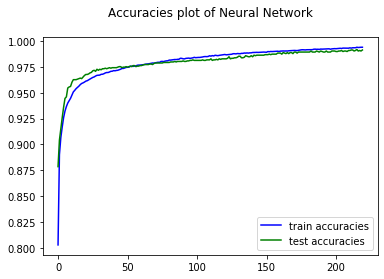

In [24]:
plt.plot(ccb.accuracies, 'b', label = 'train accuracies')
plt.plot(ccb.test_accuracies,'g', label = 'test accuracies')
plt.legend();
plt.title('Accuracies plot of Neural Network\n');

Text(0.5, 1.0, 'Losses plot of Neural Network')

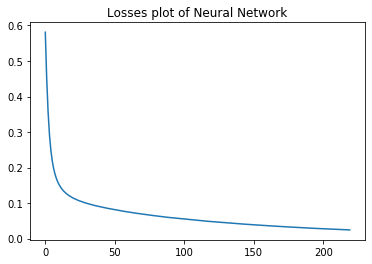

In [25]:
plt.plot(ccb.losses)
plt.title('Losses plot of Neural Network')

In [26]:
new_model = Model(layers[:-2])
inputs = new_model(X_test)
x1,x2 = np.meshgrid(inputs[:,0], inputs[:,1])
w1 = ccb.get_weights('fourth',0)[-1]
w2 = ccb.get_weights('fourth',1)[-1]
b = ccb.get_biases('fourth')[-1]

In [27]:
print(x1.max(), x1.min())
print(x2.max(), x2.min())

5.626170525812697 -8.536214669607741
4.954538708763423 -5.981903369968495


In [28]:
x1grid = np.linspace(-4,4,500)
x2grid = np.linspace(9,-6,500)
X1, X2 = np.meshgrid(x1grid, x2grid)
line = w1*X1 + w2*X2 +b
prob = layers[-1](line)

In [29]:
y_test.ravel()
b = np.argwhere(y_test ==3)
a = np.argwhere(y_test==8)

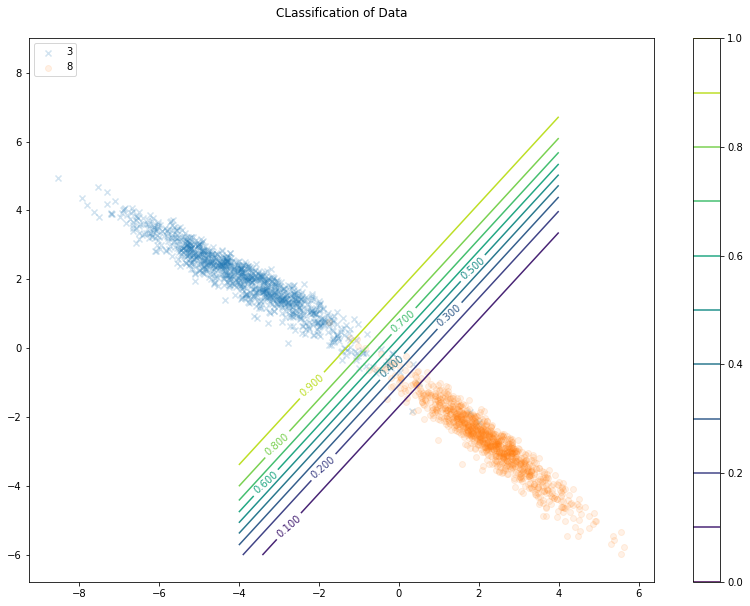

In [30]:
plt.figure(figsize=(14,10))
plt.scatter(inputs[:,0][b],inputs[:,1][b], marker = 'x', alpha = 0.2, label = '3')
plt.scatter(inputs[:,0][a],inputs[:,1][a], marker = 'o', alpha = 0.1, label = '8')
plt.legend(loc = 'upper left')
contours = plt.contour(X1, X2, prob,10)
plt.clabel(contours,inline = True, fontsize = 10);
plt.colorbar(contours);
plt.title('CLassification of Data\n');

In [31]:
matrix = confusion_matrix(y_test1,ccb.predictions)
print(f'Number of False positives: {matrix[0,1]}\n')
print(f'Number of False negatives: {matrix[1,0]}')

Number of False positives: 8

Number of False negatives: 9


In [32]:
layers_logistic = [Affine('logistic_aff',784,1),Sigmoid('sigmoid_aff')]
logistic_model = Model(layers_logistic)
learner_logistic = Learner(loss, logistic_model, opt, config.num_epochs)
ccb_logistic = CLfCallback(learner_logistic, config.bs)
learner_logistic.set_callbacks([ccb_logistic])

xavier


In [33]:
learner_logistic.train_loop(dl, X_test, y_test1)

Epoch 0 Loss 0.6579801335906548
 train accuracy: 0.6170088466032382 test accuracy: 0.7560483870967742


Epoch 10 Loss 0.27452436103629857
 train accuracy: 0.9182941078284093 test accuracy: 0.9269153225806451


Epoch 20 Loss 0.21627446893055144
 train accuracy: 0.9346519779669504 test accuracy: 0.9470766129032258


Epoch 30 Loss 0.18952421166207728
 train accuracy: 0.9410782840928059 test accuracy: 0.953125


Epoch 40 Loss 0.1736311215222868
 train accuracy: 0.9453346686696712 test accuracy: 0.9566532258064516


Epoch 50 Loss 0.16291138108545047
 train accuracy: 0.9486730095142714 test accuracy: 0.9591733870967742


Epoch 60 Loss 0.15511599168147341
 train accuracy: 0.9516775162744117 test accuracy: 0.9611895161290323


Epoch 70 Loss 0.14914206851211204
 train accuracy: 0.9542647304289767 test accuracy: 0.9611895161290323


Epoch 80 Loss 0.14438552101341998
 train accuracy: 0.9555166082457018 test accuracy: 0.9632056451612904


Epoch 90 Loss 0.14049337429853212
 train accuracy: 0.956935

0.05911612161022447

In [34]:
max(ccb_logistic.accuracies), max(ccb_logistic.test_accuracies)

(0.9623602069771323, 0.967741935483871)

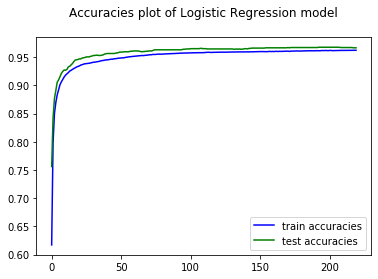

In [35]:
plt.plot(ccb_logistic.accuracies, 'b', label = 'train accuracies')
plt.plot(ccb_logistic.test_accuracies,'g', label = 'test accuracies')
plt.legend();
plt.title('Accuracies plot of Logistic Regression model\n');

In [36]:
np.array([[1,2,4,5],[2,3]]).ravel()

array([list([1, 2, 4, 5]), list([2, 3])], dtype=object)

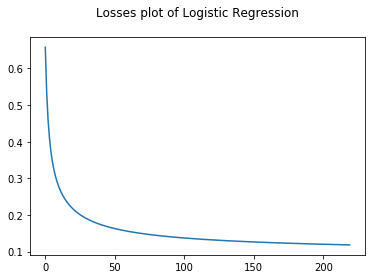

In [37]:
plt.plot(ccb_logistic.losses)
plt.title('Losses plot of Logistic Regression\n');

By these plots we can observe that when performing logistic regression instead of Neural network, our accuracy is less in logistic regression but overfitting doesn't seem to happen in logistic regression

In [38]:
confusion_matrix(y_test1, ccb_logistic.predictions)

array([[939,  35],
       [ 31, 979]])